In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2

import os
from matplotlib import pyplot as plt

from PIL import Image
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

PATCH_SIZE = 16

image = Image.open("pigeon.jpg")
sketch = Image.open("pigeon_sketch.png")
ascii_lines = Image.open("pigeon_ascii.png")
bw = Image.open("sit_toyosu.png").convert("L")
tone = Image.open("converted_sit_toyosu.png")

In [2]:
def extract_patches(image, n, m, filename=None):  
    patches = []
    image = np.array(image,float)
    height, width = image.shape[:2]
    images_height =0
    images_width = 0

    for y in range(0, height - n + 1, m):
        images_height += 1
        for x in range(0, width - n + 1, m):  
            images_width += 1          
            patch = image[y:y+n, x:x+n]
            patches.append(patch)
    images_width = images_width//images_height
    
    if filename:
        os.makedirs(filename, exist_ok=True)
        for i, patch in enumerate(patches):
            cv2.imwrite(f"{filename}/{filename}_{i}.png", patch)

    return np.array([patch for patch in patches]), images_width, images_height

In [4]:
# Assuming you have a list of image paths called 'image_paths'
# Load the images
images, _, _ = extract_patches(np.array(ascii_lines), PATCH_SIZE, PATCH_SIZE)
intra_cluster_variances = []

for image in images:
    kmeans = KMeans(n_clusters=4)  # You can adjust the number of clusters as needed
    kmeans.fit(image)

    # Print the irregularities
    intra_cluster_variance = kmeans.inertia_
    # print("Intra-cluster variance:", intra_cluster_variance)
    intra_cluster_variances.append(intra_cluster_variance)

/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/sklearn/base.py:1351: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit

In [5]:
intra_cluster_variances = np.array(intra_cluster_variances).mean()
print("Intra-cluster variance:", intra_cluster_variances)

Intra-cluster variance: 7684.462687908879


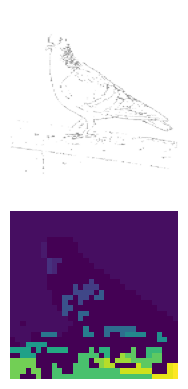

In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

img= cv2.imread('pigeon_ascii.png') 
labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

n = 0
while(n<4):
    labimg = cv2.pyrDown(labimg)
    n = n+1

feature_image=np.reshape(labimg, [-1, 3])
rows, cols, chs = labimg.shape

db = DBSCAN(eps=1, min_samples=3, metric = 'euclidean',algorithm ='auto')
db.fit(feature_image)
labels = db.labels_

indices = np.dstack(np.indices(labimg.shape[:2]))
xycolors = np.concatenate((labimg, indices), axis=-1) 
feature_image2 = np.reshape(xycolors, [-1,5])
db.fit(feature_image2)
labels2 = db.labels_

plt.figure(2)
plt.subplot(2, 1, 1)
plt.imshow(img)
plt.axis('off')

# plt.subplot(2, 1, 2)
# plt.imshow(np.reshape(labels, [rows, cols]))
# plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(np.reshape(labels2, [rows, cols]))
plt.axis('off')
plt.show()

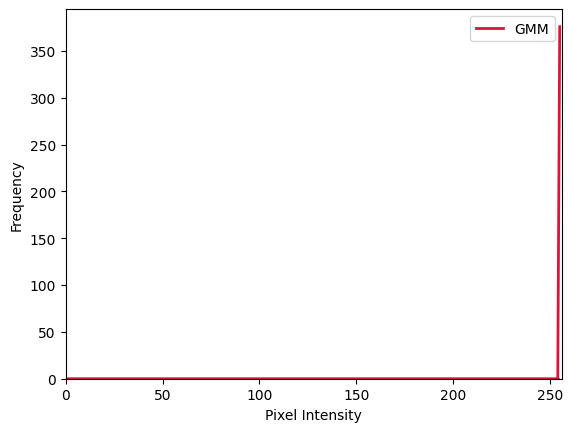

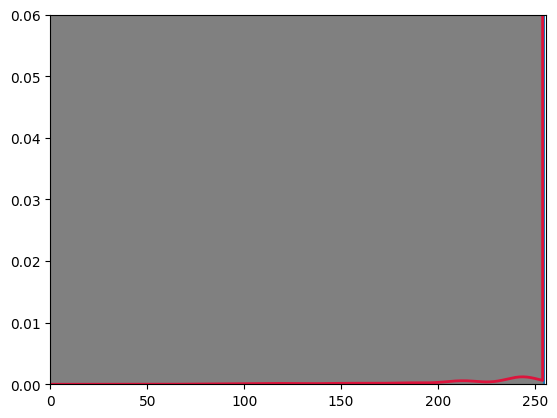

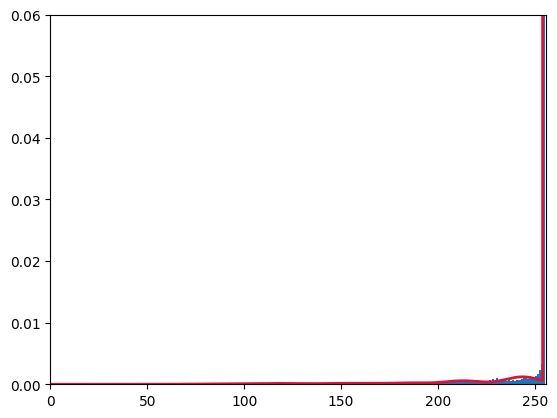

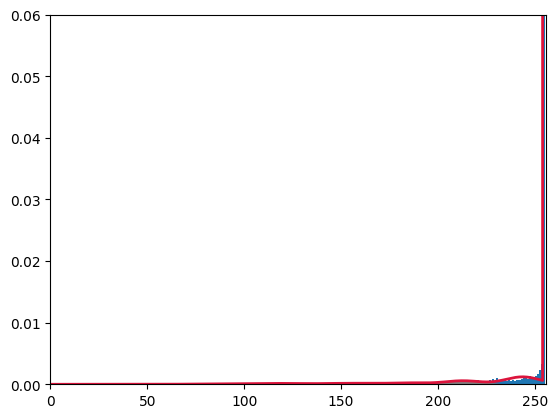

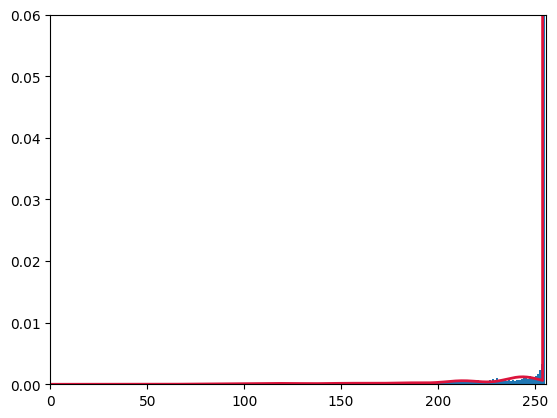

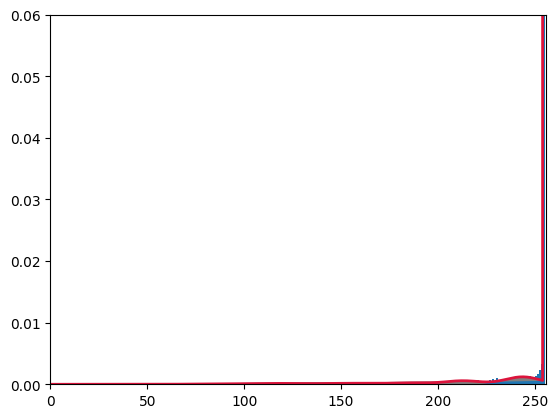

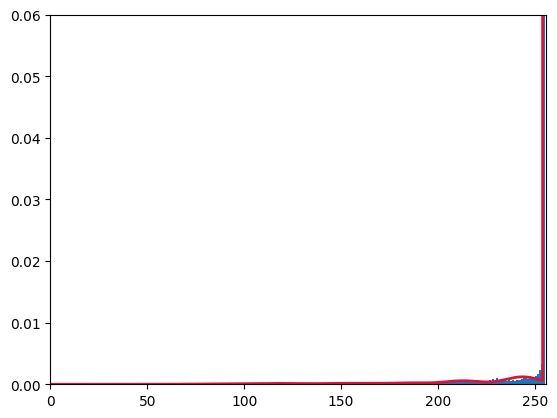

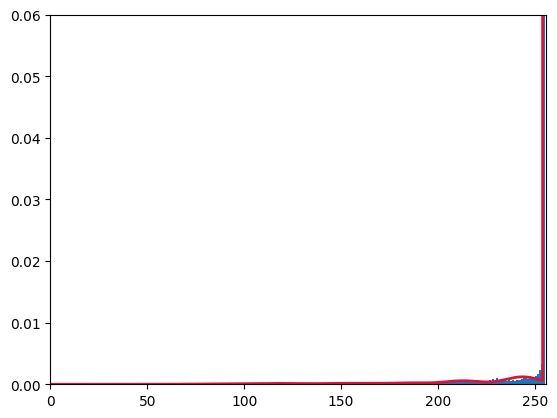

In [60]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import stats


img = cv2.imread("pigeon_ascii.png")

# Convert MxNx3 image into Kx3 where K=MxN
img2 = img.reshape((-1,3))  #-1 reshape means, in this case MxN

from sklearn.mixture import GaussianMixture as GMM

#covariance choices, full, tied, diag, spherical

k = 7
gmm_model = GMM(n_components=k, covariance_type='full').fit(img2)  #tied works better than full
gmm_labels = gmm_model.predict(img2)

#Put numbers back to original shape so we can reconstruct segmented image
original_shape = img.shape
segmented = gmm_labels.reshape(original_shape[0], original_shape[1])
# cv2.imwrite("test_s.tif", segmented)

data = img2.ravel()
#data = data[data != 0]
#data = data[data != 1]  #Removes background pixels (intensities 0 and 1)

gmm = GMM(n_components = k)
gmm = gmm.fit(X=np.expand_dims(data,1))
gmm_x = np.linspace(0,255,256)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))


gmm_model.means_

gmm_model.covariances_

gmm_model.weights_


# Plot histograms and gaussian curves
fig, ax = plt.subplots()
ax.hist(img2.ravel(),255,[2,256], density=True, stacked=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=2, label="GMM")

ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")

plt.legend()
plt.grid(False)
plt.xlim([0, 256])

plt.show()

for m in range(gmm_model.n_components):
    

    pdf = gmm_model.weights_[m] * stats.norm(gmm_model.means_[m, 0],
                                       np.sqrt(gmm_model.covariances_[m, 0])).pdf(gmm_x.reshape(-1,1))
    

    fig, ax = plt.subplots()
    ax.hist(img2.ravel(),255,[2,256], density=True, stacked=True)
    ax.plot(gmm_x, gmm_y, color="crimson", lw=2, label="GMM")
    plt.fill(gmm_x, pdf, facecolor='gray',
             edgecolor='none')
    plt.xlim(0, 256)
    plt.ylim(0, .06)